In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import argparse
import os

In [3]:
import numpy as np
import pandas as pd

In [4]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [5]:
import tensorflow as tf

In [6]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr 
    an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [8]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_sign"):
    """Plots labels and LC ATLAS signatures as function 
    of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "signs_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    sign_size = (18, 12)
    figure = np.zeros((digit_size[0] * n, digit_size[1] * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(sign_size[0], sign_size[1])
            figure[i * sign_size[0]: (i + 1) * sign_size[0],
                   j * sign_size[1]: (j + 1) * sign_size[1]] = digit

    plt.figure(figsize=(10, 10))
    start_range = sign_size[0] // 2
    end_range = n * sign_size[0] + start_range + 1
    pixel_range = np.arange(start_range, end_range, sign_size[0])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [9]:
image_size = (18, 12)
original_dim = image_size[0] * image_size[1]
#x_train = np.reshape(x_train, [-1, original_dim])
#x_test = np.reshape(x_test, [-1, original_dim])
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

In [10]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [11]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [12]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [13]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 216)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          111104      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [14]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [15]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 216)               110808    
Total params: 112,344
Trainable params: 112,344
Non-trainable params: 0
_________________________________________________________________


In [16]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 216)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 113156    
_________________________________________________________________
decoder (Model)              (None, 216)               112344    
Total params: 225,500
Trainable params: 225,500
Non-trainable params: 0
_________________________________________________________________


In [62]:
input_img = Input(shape=(18, 12, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print x.shape
x = MaxPooling2D((2, 2), padding='same')(x)
print x.shape
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print x.shape
#x = MaxPooling2D((3, 2), padding='same')(x)
#print x.shape
#x = Conv2D(8, (3, 2), activation='relu', padding='same')(x)
#print x.shape
encoded = MaxPooling2D((3, 2), padding='same')(x)
print encoded.shape

# at this point the representation is ### altered(3, 3, 8) i.e. 128-dimensional
print 'This is the bottleneck'

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print x.shape
x = UpSampling2D((3, 2))(x)
print x.shape
#x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
print x.shape
x = UpSampling2D((2, 2))(x)
print x.shape
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print decoded.shape

autoencoder = Model(input_img, decoded)

(?, 18, 12, 16)
(?, 9, 6, 16)
(?, 9, 6, 8)
(?, 3, 3, 8)
This is the bottleneck
(?, 3, 3, 8)
(?, 9, 6, 8)
(?, 9, 6, 16)
(?, 18, 12, 16)
(?, 18, 12, 1)


In [63]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(3, 3, 8))
# retrieve the last layer of the autoencoder model
decoder_layers = autoencoder.layers[-5:]

In [64]:
composed_model = decoder_layers[0](encoded_input)
composed_model = decoder_layers[1](composed_model)
composed_model = decoder_layers[2](composed_model)
composed_model = decoder_layers[3](composed_model)
composed_model = decoder_layers[4](composed_model)

In [65]:
# create the decoder model
decoder = Model(encoded_input, composed_model)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [66]:
df_mira = pd.read_csv('ATLAS_LC/MIRA_features_table.csv')
signature_cols = [col for col in df_mira.columns if 'Signature' in col]
signature_cols += ['OBJID', 'filter', 'CLASS']
df_mira = df_mira[signature_cols]

In [67]:
df_mpulse = pd.read_csv('ATLAS_LC/MPULSE_features_table.csv')[signature_cols]
df_dbf = pd.read_csv('ATLAS_LC/DBF_features_table.csv')[signature_cols]
df_lpv = pd.read_csv('ATLAS_LC/LPV_features_table.csv')[signature_cols]
df_dbh = pd.read_csv('ATLAS_LC/DBH_features_table.csv')[signature_cols]
df_pulse = pd.read_csv('ATLAS_LC/PULSE_features_table.csv')[signature_cols]
df_nsine = pd.read_csv('ATLAS_LC/NSINE_features_table.csv')[signature_cols]
df_sine = pd.read_csv('ATLAS_LC/SINE_features_table.csv')[signature_cols]
df_msine = pd.read_csv('ATLAS_LC/MSINE_features_table.csv')[signature_cols]
df_cbh = pd.read_csv('ATLAS_LC/CBH_features_table.csv')[signature_cols]
df_cbf = pd.read_csv('ATLAS_LC/CBF_features_table.csv')[signature_cols]
df_irr = pd.read_csv('ATLAS_LC/IRR_features_table.csv')[signature_cols]

In [68]:
full_data = pd.concat([df_mira, df_mpulse, df_dbf, df_lpv, df_dbh, df_pulse, 
                       df_nsine, df_sine, df_msine, df_cbf, df_cbh], sort=False)
signature_cols = [col for col in df_mira.columns if 'Signature' in col]
X = full_data[signature_cols].values

In [69]:
del(df_mira)
del(df_dbf)
del(df_lpv)
del(df_dbh)
del(df_pulse)
del(df_nsine)
del(df_sine)
del(df_msine)
del(df_cbh)
del(df_cbf)
del(df_irr)

In [70]:
data = X.reshape(X.shape[0], 18, 12, 1)

In [71]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_test = train_test_split(data, test_size=0.10, random_state=17)

In [76]:
print(X_train.shape)
print(X_test.shape)

(326278, 18, 12, 1)
(36254, 18, 12, 1)


In [77]:
from keras.callbacks import TensorBoard

In [78]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1, 2'

In [ ]:
#with tf.device(':/gpu:2'):
autoencoder.fit(X_train, X_train,
                epochs=300,
                batch_size=1000,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/users/bsanchez/tensorboard_logs/autoencoder')])

Train on 326278 samples, validate on 36254 samples
Epoch 1/300
326278/326278 [==============================] - 4s 13us/step - loss: -0.5760 - val_loss: -1.0642
Epoch 2/300
326278/326278 [==============================] - 4s 12us/step - loss: -1.1561 - val_loss: -1.2555
Epoch 3/300
326278/326278 [==============================] - 4s 11us/step - loss: -1.2855 - val_loss: -1.3310
Epoch 4/300
326278/326278 [==============================] - 4s 11us/step - loss: -1.3528 - val_loss: -1.3923
Epoch 5/300
326278/326278 [==============================] - 4s 11us/step - loss: -1.3960 - val_loss: -1.4254
Epoch 6/300
326278/326278 [==============================] - 4s 11us/step - loss: -1.4267 - val_loss: -1.4458
Epoch 7/300
326278/326278 [==============================] - 3s 11us/step - loss: -1.4510 - val_loss: -1.4811
Epoch 8/300
326278/326278 [==============================] - 4s 11us/step - loss: -1.4687 - val_loss: -1.4702
Epoch 9/300
326278/326278 [==============================] - 4s 11us/

In [84]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
# encode and decode some lightcurves
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [85]:
decoded_imgs_full = autoencoder.predict(X_test)

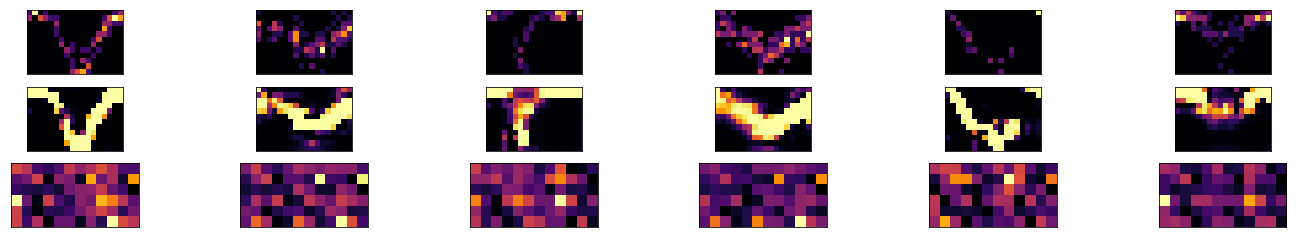

In [96]:
n = 6  # how many digits we will display
plt.figure(figsize=(24, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    j = np.random.randint(0, high=len(X_test))
    plt.imshow(X_test[j, :, :, 0].T, cmap='inferno')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_full[j, :, :, 0].T, cmap='inferno')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded view
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(encoded_imgs[j].reshape(12, 6).T, cmap='inferno')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [99]:
# encode every data 
encoded_imgs = encoder.predict(data)
encoded_imgs.shape

(362532, 3, 3, 8)

In [100]:
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape

(362532, 18, 12, 1)

In [103]:
np.save('deep_encoded_signatures.npy', encoded_imgs)
np.save('deep_decoded_signatures.npy', decoded_imgs)